In [1]:
import numpy as np
import torch
## import torch.nn as nn
import torch.nn.functional as F
import gym
from collections import deque
import random
import matplotlib.pyplot as plt

import time
from TD3_Fork import TD3_FORK

env = gym.make('BipedalWalkerHardcore-v3')
agent = TD3_FORK(env, batch_size = 100)

threshold = env.spec.reward_threshold
max_steps = env._max_episode_steps
print(' threshold: ', threshold, ', max_steps: ', max_steps)

start_timestep=10000 # it was 0            #time_step to select action based on Actor


D:\Users\user\Anaconda2_02Aug2019\envs\ml2\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


 threshold:  300 , max_steps:  2000


In [2]:
# save(agent = agent, filename='checkpnt, directory = 'dir_chkpoint')     
def save(agent, directory, filename, episode, reward):
    torch.save(agent.actor.state_dict(), '%s/%s_actor_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.sysmodel.state_dict(), '%s/%s_sysmodel_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.actor_target.state_dict(), '%s/%s_actor_target_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.critic_target.state_dict(), '%s/%s_critic_target_%s_%s.pth' % (directory, filename, episode, reward))
    

In [3]:
def td3_fork_train(total_episodes=40000):
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    num_steps_deque = deque(maxlen=100)
    avg_numm_steps_array = []
    
    total_timesteps = 0
    sys_loss = 0
    expcount = 0
    totrain = 0
    falling_down = 0

    time_start = time.time()                   # Init start time
    
    for i_episode in range(total_episodes):
        state = env.reset()
        episode_reward = 0
        episode_steps = 0
        timestep = 0
        temp_replay_buffer = []

        for st in range(max_steps):

            # Select action randomly or according to policy
            if total_timesteps < start_timestep:
                action = env.action_space.sample()
            else:
                ## std_noice is moved into agent.policy
                action = agent.policy(state)

            # Recieve state and reward from environment.
            next_state, reward, done, info = env.step(action)
            #change original reward from -100 to -5 and 5*reward for other values
            episode_reward += reward
            episode_steps += 1
            
            if reward == -100:
                add_reward = -1
                reward = -5
                falling_down += 1
                expcount += 1
            else:
                add_reward = 0
                reward = 5 * reward

            temp_replay_buffer.append((state, action, reward, add_reward, next_state, done))
            
            # End this episode when `done` is True
            if done:
                if add_reward == -1 or episode_reward < 250:            
                    totrain = 1
                    for temp in temp_replay_buffer: 
                        agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
                elif expcount > 0 and np.random.rand() > 0.5:
                    totrain = 1
                    expcount -= 10
                    for temp in temp_replay_buffer: 
                        agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
                break
            state = next_state
            timestep += 1     
            total_timesteps += 1
        
        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        num_steps_deque.append(episode_steps)
        avg_num_steps = np.mean(num_steps_deque)
        avg_numm_steps_array.append(avg_num_steps)


        #Training agent only when new experiences are added to the replay buffer
        weight =  1 - np.clip(avg_score/300, 0, 1)
        if totrain == 1:
            sys_loss = agent.learn_and_update_weights_by_replay(timestep, weight, totrain)
        else: 
            sys_loss = agent.learn_and_update_weights_by_replay(100, weight, totrain)
        totrain = 0

        if i_episode % 200 == 0 and i_episode > 0:
            reward_round = round(episode_reward, 2)
            save(agent, 'dir_bpw_td3_fork', 'weights', str(i_episode), str(reward_round))
        
        if i_episode % 10 == 0 and i_episode > 0:  

            s = (int)(time.time() - time_start)
            min_score = np.min(scores_deque)
            max_score = np.max(scores_deque)
            med_score = np.median(scores_deque)
            print("Ep.: {}, Avg.Num.St.: {:.1f}, Min-Max.Sc.: ({:.2f}, {:.2f}), Med.Sc.:{:.3f}, Avg.Sc.: {:.3f}, Time: {:02}:{:02}:{:02}, F.D.: {}, weight: {:.3f}".\
                format(i_episode, avg_num_steps, min_score, max_score, med_score, avg_score, \
                  s//3600, s%3600//60, s%60, falling_down, weight ))
            
        if (avg_score >= threshold):            
            print('Solved environment with Avg Score:  ', avg_score)
            print('total_timesteps: ', total_timesteps)
            break;
            

    return scores_array, avg_scores_array, avg_numm_steps_array 

scores, avg_scores, avg_numm_steps = td3_fork_train()


Ep.: 10, Avg.Num.St.: 427.5, Min-Max.Sc.: (-122.28, -98.23), Med.Sc.:-103.949, Avg.Sc.: -106.965, Time: 00:00:01, F.D.: 9, weight: 1.000
Ep.: 20, Avg.Num.St.: 533.3, Min-Max.Sc.: (-122.28, -60.83), Med.Sc.:-105.076, Avg.Sc.: -105.852, Time: 00:01:05, F.D.: 16, weight: 1.000
Ep.: 30, Avg.Num.St.: 382.2, Min-Max.Sc.: (-122.28, -60.83), Med.Sc.:-105.076, Avg.Sc.: -104.758, Time: 00:01:24, F.D.: 26, weight: 1.000
Ep.: 40, Avg.Num.St.: 316.1, Min-Max.Sc.: (-122.28, -60.83), Med.Sc.:-102.951, Avg.Sc.: -103.831, Time: 00:01:58, F.D.: 36, weight: 1.000
Ep.: 50, Avg.Num.St.: 271.2, Min-Max.Sc.: (-122.28, -60.83), Med.Sc.:-101.564, Avg.Sc.: -102.809, Time: 00:02:28, F.D.: 46, weight: 1.000
Ep.: 60, Avg.Num.St.: 240.0, Min-Max.Sc.: (-122.28, -60.83), Med.Sc.:-100.915, Avg.Sc.: -101.901, Time: 00:03:00, F.D.: 56, weight: 1.000
Ep.: 70, Avg.Num.St.: 215.9, Min-Max.Sc.: (-122.28, -60.83), Med.Sc.:-100.221, Avg.Sc.: -101.471, Time: 00:03:23, F.D.: 66, weight: 1.000
Ep.: 80, Avg.Num.St.: 198.3, Min-Ma

Ep.: 600, Avg.Num.St.: 374.3, Min-Max.Sc.: (-121.55, 307.83), Med.Sc.:-23.753, Avg.Sc.: -2.622, Time: 01:23:33, F.D.: 583, weight: 1.000
Ep.: 610, Avg.Num.St.: 354.0, Min-Max.Sc.: (-121.55, 307.83), Med.Sc.:-26.756, Avg.Sc.: -8.270, Time: 01:25:44, F.D.: 593, weight: 1.000
Ep.: 620, Avg.Num.St.: 360.2, Min-Max.Sc.: (-121.55, 307.83), Med.Sc.:-24.713, Avg.Sc.: -7.246, Time: 01:28:06, F.D.: 603, weight: 1.000
Ep.: 630, Avg.Num.St.: 360.1, Min-Max.Sc.: (-121.55, 308.29), Med.Sc.:-27.876, Avg.Sc.: -8.880, Time: 01:30:40, F.D.: 612, weight: 1.000
Ep.: 640, Avg.Num.St.: 359.8, Min-Max.Sc.: (-121.55, 308.29), Med.Sc.:-31.779, Avg.Sc.: -11.171, Time: 01:32:58, F.D.: 622, weight: 1.000
Ep.: 650, Avg.Num.St.: 389.7, Min-Max.Sc.: (-100.03, 308.29), Med.Sc.:-28.965, Avg.Sc.: 1.433, Time: 01:36:02, F.D.: 629, weight: 0.995
Ep.: 660, Avg.Num.St.: 409.4, Min-Max.Sc.: (-100.03, 308.29), Med.Sc.:-31.603, Avg.Sc.: -0.803, Time: 01:39:18, F.D.: 637, weight: 1.000
Ep.: 670, Avg.Num.St.: 421.3, Min-Max.Sc.

Ep.: 1190, Avg.Num.St.: 659.1, Min-Max.Sc.: (-86.77, 313.99), Med.Sc.:103.370, Avg.Sc.: 137.228, Time: 04:24:40, F.D.: 1042, weight: 0.543
Ep.: 1200, Avg.Num.St.: 656.5, Min-Max.Sc.: (-86.77, 313.99), Med.Sc.:107.247, Avg.Sc.: 135.131, Time: 04:27:37, F.D.: 1048, weight: 0.550
Ep.: 1210, Avg.Num.St.: 654.0, Min-Max.Sc.: (-86.77, 313.99), Med.Sc.:112.125, Avg.Sc.: 135.997, Time: 04:31:18, F.D.: 1053, weight: 0.547
Ep.: 1220, Avg.Num.St.: 664.4, Min-Max.Sc.: (-86.77, 313.99), Med.Sc.:112.125, Avg.Sc.: 141.195, Time: 04:34:18, F.D.: 1059, weight: 0.529
Ep.: 1230, Avg.Num.St.: 665.4, Min-Max.Sc.: (-86.77, 313.99), Med.Sc.:103.225, Avg.Sc.: 135.473, Time: 04:38:36, F.D.: 1065, weight: 0.548
Ep.: 1240, Avg.Num.St.: 676.4, Min-Max.Sc.: (-86.77, 313.99), Med.Sc.:141.007, Avg.Sc.: 143.204, Time: 04:41:36, F.D.: 1070, weight: 0.523
Ep.: 1250, Avg.Num.St.: 702.8, Min-Max.Sc.: (-86.27, 311.96), Med.Sc.:157.632, Avg.Sc.: 153.584, Time: 04:44:56, F.D.: 1076, weight: 0.488
Ep.: 1260, Avg.Num.St.: 714

Ep.: 1770, Avg.Num.St.: 840.5, Min-Max.Sc.: (-135.84, 314.18), Med.Sc.:305.765, Avg.Sc.: 232.674, Time: 06:34:46, F.D.: 1256, weight: 0.224
Ep.: 1780, Avg.Num.St.: 818.5, Min-Max.Sc.: (-135.84, 314.18), Med.Sc.:305.539, Avg.Sc.: 218.784, Time: 06:37:39, F.D.: 1262, weight: 0.271
Ep.: 1790, Avg.Num.St.: 812.0, Min-Max.Sc.: (-135.84, 314.18), Med.Sc.:304.885, Avg.Sc.: 215.057, Time: 06:38:42, F.D.: 1265, weight: 0.283
Ep.: 1800, Avg.Num.St.: 808.6, Min-Max.Sc.: (-135.84, 314.18), Med.Sc.:304.847, Avg.Sc.: 214.313, Time: 06:40:16, F.D.: 1268, weight: 0.286
Ep.: 1810, Avg.Num.St.: 799.5, Min-Max.Sc.: (-85.57, 314.18), Med.Sc.:305.139, Avg.Sc.: 219.755, Time: 06:41:39, F.D.: 1271, weight: 0.267
Ep.: 1820, Avg.Num.St.: 784.7, Min-Max.Sc.: (-85.57, 312.05), Med.Sc.:304.885, Avg.Sc.: 212.869, Time: 06:43:33, F.D.: 1275, weight: 0.290
Ep.: 1830, Avg.Num.St.: 785.2, Min-Max.Sc.: (-68.75, 311.02), Med.Sc.:304.761, Avg.Sc.: 214.030, Time: 06:44:48, F.D.: 1278, weight: 0.287
Ep.: 1840, Avg.Num.St.:

Ep.: 2350, Avg.Num.St.: 832.3, Min-Max.Sc.: (-101.69, 311.54), Med.Sc.:304.818, Avg.Sc.: 240.797, Time: 08:20:10, F.D.: 1443, weight: 0.197
Ep.: 2360, Avg.Num.St.: 820.9, Min-Max.Sc.: (-101.69, 311.54), Med.Sc.:304.757, Avg.Sc.: 234.308, Time: 08:22:27, F.D.: 1448, weight: 0.219
Ep.: 2370, Avg.Num.St.: 826.8, Min-Max.Sc.: (-101.69, 311.54), Med.Sc.:304.886, Avg.Sc.: 237.214, Time: 08:24:05, F.D.: 1450, weight: 0.209
Ep.: 2380, Avg.Num.St.: 824.0, Min-Max.Sc.: (-101.69, 311.54), Med.Sc.:304.984, Avg.Sc.: 236.133, Time: 08:26:40, F.D.: 1454, weight: 0.213
Ep.: 2390, Avg.Num.St.: 818.7, Min-Max.Sc.: (-101.69, 310.34), Med.Sc.:304.758, Avg.Sc.: 232.118, Time: 08:28:14, F.D.: 1457, weight: 0.226
Ep.: 2400, Avg.Num.St.: 828.4, Min-Max.Sc.: (-101.69, 310.34), Med.Sc.:304.467, Avg.Sc.: 237.348, Time: 08:29:43, F.D.: 1459, weight: 0.209
Ep.: 2410, Avg.Num.St.: 831.0, Min-Max.Sc.: (-101.69, 309.71), Med.Sc.:304.853, Avg.Sc.: 240.209, Time: 08:31:09, F.D.: 1461, weight: 0.199
Ep.: 2420, Avg.Num.S

Ep.: 2930, Avg.Num.St.: 833.0, Min-Max.Sc.: (-62.11, 312.91), Med.Sc.:306.047, Avg.Sc.: 250.338, Time: 10:05:53, F.D.: 1607, weight: 0.166
Ep.: 2940, Avg.Num.St.: 833.3, Min-Max.Sc.: (-62.11, 312.91), Med.Sc.:305.653, Avg.Sc.: 248.139, Time: 10:07:29, F.D.: 1609, weight: 0.173
Ep.: 2950, Avg.Num.St.: 836.0, Min-Max.Sc.: (-81.25, 312.91), Med.Sc.:306.030, Avg.Sc.: 249.878, Time: 10:10:11, F.D.: 1612, weight: 0.167
Ep.: 2960, Avg.Num.St.: 834.2, Min-Max.Sc.: (-81.25, 312.91), Med.Sc.:305.885, Avg.Sc.: 248.297, Time: 10:11:49, F.D.: 1615, weight: 0.172
Ep.: 2970, Avg.Num.St.: 807.2, Min-Max.Sc.: (-81.25, 312.91), Med.Sc.:305.495, Avg.Sc.: 235.316, Time: 10:13:59, F.D.: 1621, weight: 0.216
Ep.: 2980, Avg.Num.St.: 791.8, Min-Max.Sc.: (-85.65, 312.91), Med.Sc.:305.283, Avg.Sc.: 227.849, Time: 10:16:30, F.D.: 1625, weight: 0.241
Ep.: 2990, Avg.Num.St.: 794.9, Min-Max.Sc.: (-85.65, 312.61), Med.Sc.:304.948, Avg.Sc.: 229.056, Time: 10:18:04, F.D.: 1627, weight: 0.236
Ep.: 3000, Avg.Num.St.: 795

Ep.: 3510, Avg.Num.St.: 856.8, Min-Max.Sc.: (-74.51, 315.70), Med.Sc.:306.536, Avg.Sc.: 261.672, Time: 11:44:20, F.D.: 1744, weight: 0.128
Ep.: 3520, Avg.Num.St.: 868.0, Min-Max.Sc.: (-74.51, 315.70), Med.Sc.:306.751, Avg.Sc.: 265.065, Time: 11:46:06, F.D.: 1746, weight: 0.116
Ep.: 3530, Avg.Num.St.: 867.1, Min-Max.Sc.: (-74.51, 315.70), Med.Sc.:306.464, Avg.Sc.: 264.077, Time: 11:47:11, F.D.: 1747, weight: 0.120
Ep.: 3540, Avg.Num.St.: 860.2, Min-Max.Sc.: (-74.51, 315.70), Med.Sc.:306.536, Avg.Sc.: 260.127, Time: 11:49:23, F.D.: 1750, weight: 0.133
Ep.: 3550, Avg.Num.St.: 859.4, Min-Max.Sc.: (-74.51, 315.70), Med.Sc.:306.241, Avg.Sc.: 257.354, Time: 11:51:58, F.D.: 1753, weight: 0.142
Ep.: 3560, Avg.Num.St.: 846.4, Min-Max.Sc.: (-74.51, 315.70), Med.Sc.:306.317, Avg.Sc.: 253.620, Time: 11:53:19, F.D.: 1755, weight: 0.155
Ep.: 3570, Avg.Num.St.: 853.6, Min-Max.Sc.: (-65.06, 315.70), Med.Sc.:306.395, Avg.Sc.: 258.468, Time: 11:54:41, F.D.: 1757, weight: 0.138
Ep.: 3580, Avg.Num.St.: 852

Ep.: 4090, Avg.Num.St.: 868.5, Min-Max.Sc.: (-70.99, 313.81), Med.Sc.:308.371, Avg.Sc.: 270.836, Time: 13:11:34, F.D.: 1853, weight: 0.097
Ep.: 4100, Avg.Num.St.: 878.5, Min-Max.Sc.: (-70.99, 313.48), Med.Sc.:308.315, Avg.Sc.: 277.924, Time: 13:12:19, F.D.: 1853, weight: 0.074
Ep.: 4110, Avg.Num.St.: 882.5, Min-Max.Sc.: (-70.99, 313.48), Med.Sc.:308.278, Avg.Sc.: 281.019, Time: 13:13:08, F.D.: 1854, weight: 0.063
Ep.: 4120, Avg.Num.St.: 873.5, Min-Max.Sc.: (-70.99, 314.13), Med.Sc.:308.248, Avg.Sc.: 277.188, Time: 13:15:29, F.D.: 1858, weight: 0.076
Ep.: 4130, Avg.Num.St.: 868.3, Min-Max.Sc.: (-42.34, 314.13), Med.Sc.:307.810, Avg.Sc.: 272.104, Time: 13:18:22, F.D.: 1862, weight: 0.093
Ep.: 4140, Avg.Num.St.: 866.8, Min-Max.Sc.: (-42.34, 314.13), Med.Sc.:307.783, Avg.Sc.: 270.055, Time: 13:19:34, F.D.: 1863, weight: 0.100
Ep.: 4150, Avg.Num.St.: 876.6, Min-Max.Sc.: (-42.34, 314.13), Med.Sc.:307.658, Avg.Sc.: 271.810, Time: 13:21:53, F.D.: 1866, weight: 0.094
Ep.: 4160, Avg.Num.St.: 877

Ep.: 4670, Avg.Num.St.: 879.1, Min-Max.Sc.: (20.73, 312.63), Med.Sc.:307.004, Avg.Sc.: 280.930, Time: 14:36:03, F.D.: 1943, weight: 0.064
Ep.: 4680, Avg.Num.St.: 875.8, Min-Max.Sc.: (20.73, 312.63), Med.Sc.:307.025, Avg.Sc.: 275.622, Time: 14:40:26, F.D.: 1947, weight: 0.081
Ep.: 4690, Avg.Num.St.: 873.1, Min-Max.Sc.: (-34.83, 312.96), Med.Sc.:307.411, Avg.Sc.: 276.002, Time: 14:42:12, F.D.: 1949, weight: 0.080
Ep.: 4700, Avg.Num.St.: 865.5, Min-Max.Sc.: (-34.90, 314.33), Med.Sc.:307.611, Avg.Sc.: 271.633, Time: 14:44:53, F.D.: 1952, weight: 0.095
Ep.: 4710, Avg.Num.St.: 867.8, Min-Max.Sc.: (-34.90, 314.33), Med.Sc.:307.722, Avg.Sc.: 274.902, Time: 14:46:09, F.D.: 1952, weight: 0.084
Ep.: 4720, Avg.Num.St.: 861.2, Min-Max.Sc.: (-34.90, 314.33), Med.Sc.:307.653, Avg.Sc.: 270.710, Time: 14:48:29, F.D.: 1955, weight: 0.098
Ep.: 4730, Avg.Num.St.: 859.2, Min-Max.Sc.: (-34.90, 314.33), Med.Sc.:307.604, Avg.Sc.: 269.580, Time: 14:49:25, F.D.: 1956, weight: 0.101
Ep.: 4740, Avg.Num.St.: 857.6

Ep.: 5250, Avg.Num.St.: 885.8, Min-Max.Sc.: (-54.86, 314.33), Med.Sc.:306.806, Avg.Sc.: 278.900, Time: 16:02:37, F.D.: 2048, weight: 0.070
Ep.: 5260, Avg.Num.St.: 895.6, Min-Max.Sc.: (-54.86, 314.33), Med.Sc.:306.873, Avg.Sc.: 285.560, Time: 16:03:17, F.D.: 2048, weight: 0.048
Ep.: 5270, Avg.Num.St.: 897.1, Min-Max.Sc.: (-54.86, 314.33), Med.Sc.:306.671, Avg.Sc.: 285.740, Time: 16:04:28, F.D.: 2049, weight: 0.048
Ep.: 5280, Avg.Num.St.: 894.2, Min-Max.Sc.: (-54.86, 310.72), Med.Sc.:306.992, Avg.Sc.: 286.062, Time: 16:06:37, F.D.: 2051, weight: 0.046
Ep.: 5290, Avg.Num.St.: 905.8, Min-Max.Sc.: (-22.20, 310.72), Med.Sc.:307.020, Avg.Sc.: 293.923, Time: 16:07:17, F.D.: 2051, weight: 0.020
Ep.: 5300, Avg.Num.St.: 910.0, Min-Max.Sc.: (20.82, 310.45), Med.Sc.:306.777, Avg.Sc.: 295.062, Time: 16:08:20, F.D.: 2052, weight: 0.016
Ep.: 5310, Avg.Num.St.: 910.5, Min-Max.Sc.: (20.82, 310.44), Med.Sc.:306.510, Avg.Sc.: 294.800, Time: 16:09:00, F.D.: 2052, weight: 0.017
Ep.: 5320, Avg.Num.St.: 906.7

Ep.: 5840, Avg.Num.St.: 886.6, Min-Max.Sc.: (8.65, 313.23), Med.Sc.:306.376, Avg.Sc.: 289.560, Time: 17:08:29, F.D.: 2113, weight: 0.035
Ep.: 5850, Avg.Num.St.: 878.1, Min-Max.Sc.: (8.65, 313.23), Med.Sc.:306.599, Avg.Sc.: 285.871, Time: 17:09:53, F.D.: 2115, weight: 0.047
Ep.: 5860, Avg.Num.St.: 874.4, Min-Max.Sc.: (8.65, 313.23), Med.Sc.:306.881, Avg.Sc.: 282.971, Time: 17:11:29, F.D.: 2117, weight: 0.057
Ep.: 5870, Avg.Num.St.: 879.4, Min-Max.Sc.: (-10.62, 313.23), Med.Sc.:306.941, Avg.Sc.: 283.865, Time: 17:12:18, F.D.: 2118, weight: 0.054
Ep.: 5880, Avg.Num.St.: 880.5, Min-Max.Sc.: (-10.62, 313.23), Med.Sc.:306.941, Avg.Sc.: 283.938, Time: 17:12:57, F.D.: 2118, weight: 0.054
Ep.: 5890, Avg.Num.St.: 878.4, Min-Max.Sc.: (-10.62, 313.23), Med.Sc.:306.908, Avg.Sc.: 282.054, Time: 17:14:02, F.D.: 2119, weight: 0.060
Ep.: 5900, Avg.Num.St.: 883.1, Min-Max.Sc.: (-10.62, 312.15), Med.Sc.:306.469, Avg.Sc.: 283.273, Time: 17:15:03, F.D.: 2120, weight: 0.056
Ep.: 5910, Avg.Num.St.: 876.5, Mi

Ep.: 6420, Avg.Num.St.: 904.3, Min-Max.Sc.: (-24.55, 311.26), Med.Sc.:306.073, Avg.Sc.: 291.987, Time: 18:13:23, F.D.: 2182, weight: 0.027
Ep.: 6430, Avg.Num.St.: 907.1, Min-Max.Sc.: (-24.55, 311.26), Med.Sc.:306.480, Avg.Sc.: 293.457, Time: 18:14:03, F.D.: 2182, weight: 0.022
Ep.: 6440, Avg.Num.St.: 912.1, Min-Max.Sc.: (-24.55, 311.26), Med.Sc.:306.240, Avg.Sc.: 293.417, Time: 18:14:44, F.D.: 2182, weight: 0.022
Ep.: 6450, Avg.Num.St.: 918.7, Min-Max.Sc.: (-24.55, 311.26), Med.Sc.:306.240, Avg.Sc.: 295.334, Time: 18:15:24, F.D.: 2182, weight: 0.016
Ep.: 6460, Avg.Num.St.: 908.8, Min-Max.Sc.: (-24.55, 311.26), Med.Sc.:306.049, Avg.Sc.: 289.988, Time: 18:16:34, F.D.: 2184, weight: 0.033
Ep.: 6470, Avg.Num.St.: 916.5, Min-Max.Sc.: (-24.55, 311.60), Med.Sc.:306.069, Avg.Sc.: 293.514, Time: 18:17:14, F.D.: 2184, weight: 0.022
Ep.: 6480, Avg.Num.St.: 922.2, Min-Max.Sc.: (-16.24, 311.60), Med.Sc.:306.069, Avg.Sc.: 294.847, Time: 18:18:03, F.D.: 2185, weight: 0.017
Ep.: 6490, Avg.Num.St.: 925

In [4]:
reward_round = round(np.max(scores), 2)
save(agent, 'dir_bpw_td3_fork', 'weights', 'final', str(reward_round))

length of scores:  6783 , len of avg_scores:  6783


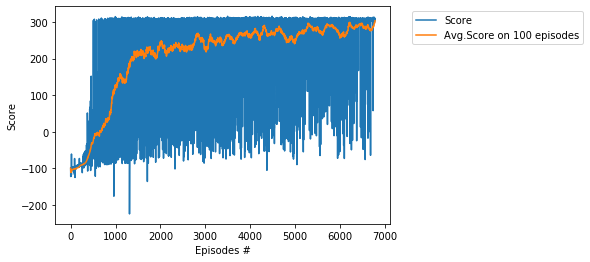

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg.Score on 100 episodes")
## plt.plot(np.arange(1, len(avg_numm_steps)+1), avg_numm_steps, label="Avg.Num.Steps on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

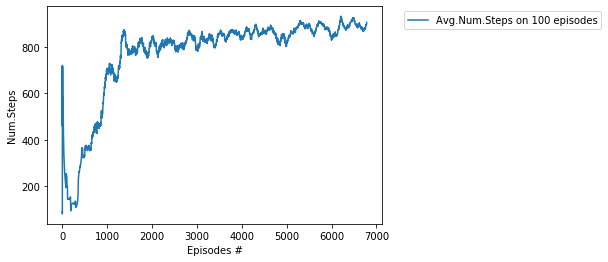

In [6]:
fig2 = plt.figure()
ax = fig2.add_subplot(111)
plt.plot(np.arange(1, len(avg_numm_steps)+1), avg_numm_steps, label="Avg.Num.Steps on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Num.Steps')
plt.xlabel('Episodes #')
plt.show()

In [ ]:
env.close()